In [1]:
import matplotlib.pyplot as plt
import subprocess

# Throughput

In [2]:
throughput_repeat = 10000
n_pub = 1
n_sub = 1
n_channel = 4

In [3]:
#CLOA
batcmd=f"ssh ec2-user@52.3.187.162 -i ~/cloakey.pem ./bench 172.31.21.234 4242 {throughput_repeat} {n_pub} {n_sub} {n_channel}"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()

result_ls = result.split('rps')
pub_throughput = result_ls[0].split(' ')[-1]
sub_throughput = result_ls[1].split(' ')[-1]
cloa_throughput = list(map(int , [pub_throughput, sub_throughput]))

In [4]:
# Redis
batcmd=f"ssh ec2-user@52.3.187.162 -i ~/cloakey.pem ./bench 172.31.21.234 6379 {throughput_repeat} {n_pub} {n_sub} {n_channel} redis"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()

result_ls = result.split('rps')
pub_throughput = result_ls[0].split(' ')[-1]
sub_throughput = result_ls[1].split(' ')[-1]
redis_throughput = list(map(int,[pub_throughput, sub_throughput]))

In [5]:
# Redis-C
batcmd=f"ssh ec2-user@3.229.231.220 -i ~/cloakey.pem ./bench 172.31.21.234 5000 {throughput_repeat} {n_pub} {n_sub} {n_channel} redis"
result = subprocess.check_output(batcmd, shell=True, text = True)
result = result.strip()

result_ls = result.split('rps')
pub_throughput = result_ls[0].split(' ')[-1]
sub_throughput = result_ls[1].split(' ')[-1]
redis_c_throughput = list(map(int,[pub_throughput, sub_throughput]))

# E2E Latency

In [6]:
REPEAT = 10000

In [7]:
import re
p = re.compile('avg Latency ([0-9|.]*)')

In [8]:
#redis
batcmd = f"ssh ec2-user@18.235.181.217 -i ~/cloakey.pem ./e2e -h 172.31.21.234:6379 -b redis -c {REPEAT}"
result = subprocess.check_output(batcmd, shell=True, text = True)
result

m = p.search(result)
cloa_e2e_latency = [float(m.group(1))]

In [9]:
#cloa
batcmd = f"ssh ec2-user@18.235.181.217 -i ~/cloakey.pem ./e2e -h 172.31.21.234:4242 -b cloa -c {REPEAT}"
result = subprocess.check_output(batcmd, shell=True, text = True)
result

m = p.search(result)

redis_e2e_latency = [float(m.group(1))]

In [10]:
#redis-c
batcmd = f"ssh ec2-user@18.235.181.217 -i ~/cloakey.pem ./e2e -h 172.31.21.234:6379 -b redis -c {REPEAT}"
result = subprocess.check_output(batcmd, shell=True, text = True)
result

m = p.search(result)
redis_c_e2e_latency = [float(m.group(1))]

In [11]:
%matplotlib notebook

<IPython.core.display.Javascript object>


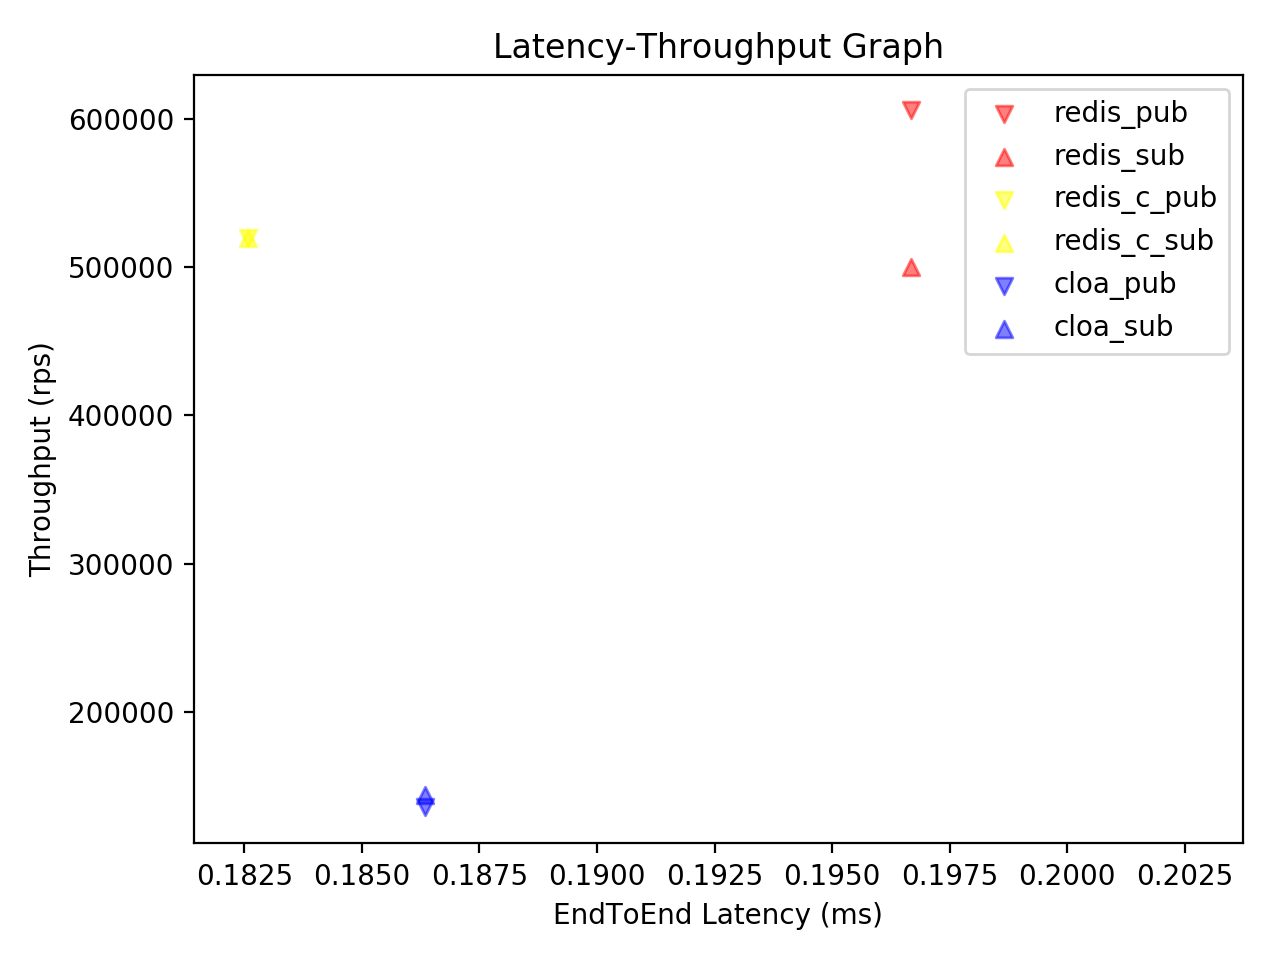

In [12]:
plt.scatter(redis_e2e_latency[0],redis_throughput[0], label = "redis_pub",  color= "red", alpha = 0.5, marker = 'v')
plt.scatter(redis_e2e_latency[0],redis_throughput[1], label = "redis_sub", color= "red", alpha = 0.5, marker = '^')

plt.scatter(redis_c_e2e_latency[0],redis_c_throughput[0], label = "redis_c_pub",  color= "yellow", alpha = 0.5, marker = 'v')
plt.scatter(redis_c_e2e_latency[0],redis_c_throughput[1], label = "redis_c_sub", color= "yellow", alpha = 0.5, marker = '^')

plt.scatter(cloa_e2e_latency[0],cloa_throughput[0], label = "cloa_pub", color = "blue", alpha = 0.5, marker = 'v')
plt.scatter(cloa_e2e_latency[0],cloa_throughput[1], label = "cloa_sub", color = "blue", alpha = 0.5, marker = '^')


plt.legend()
plt.xlabel("EndToEnd Latency (ms)")
plt.ylabel("Throughput (rps)")
plt.title("Latency-Throughput Graph")
plt.tight_layout()
plt.show()